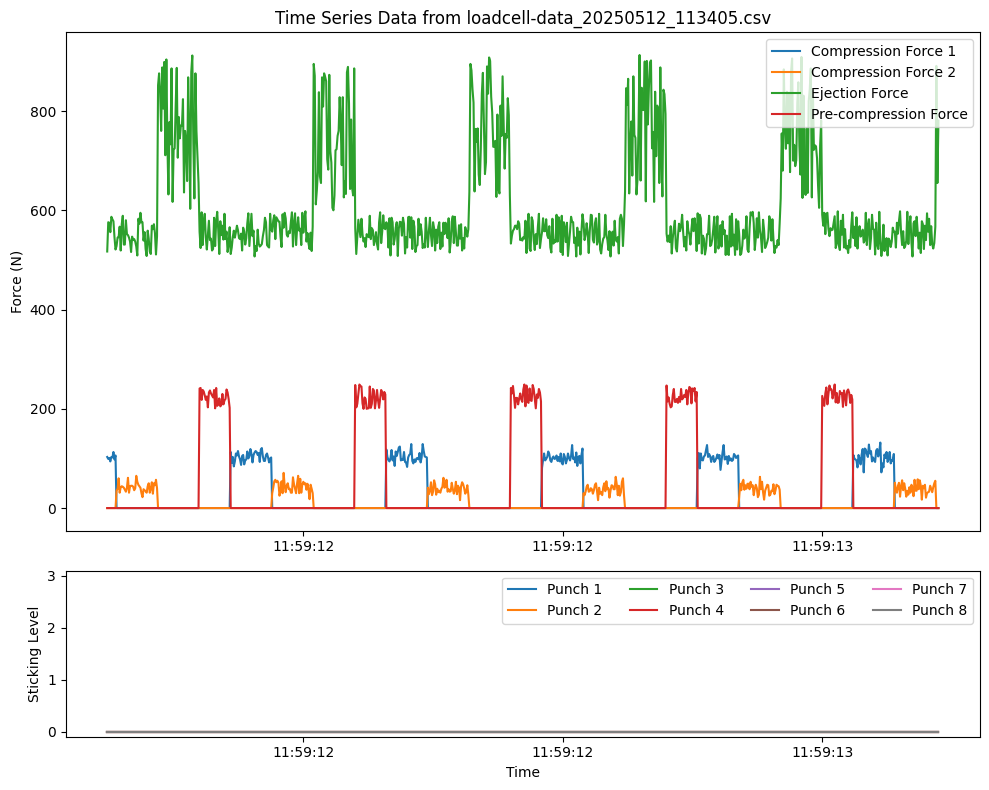

Data collection interrupted by user.


In [ ]:
import os
import time
import csv
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import numpy as np
import pandas as pd
import datetime
from pathlib import Path

print(sys.executable)
plt.ion()  # Interactive mode on

# DummySerial simulates sensor data output
class DummySerial:
    def __init__(self, port, baud, timeout=1):
        self.port = port
        self.baud = baud
        self.timeout = timeout
        self.counter = 0
        self.in_sticking_phase = False
        self.sticking_counter = 0
        self.sticking_punch = None  # Track which punch is sticking

    def readline(self):
        # Simulate sensor delay (can reduce for faster simulation)
        time.sleep(0.01)  # Reduced for faster simulation but maintain realism
        self.counter += 1

        # Get current time for timestamp fields
        # Unix timestamp in milliseconds (increments by 2000 based on CSV pattern)
        ts = str(self.counter * 2000)
        
        # Create actual time that increments by exactly 2ms per record
        # Use current time as base, truncated to the second for clean millisecond values
        if not hasattr(self, 'base_time'):
            now = datetime.datetime.now()
            self.base_time = datetime.datetime(now.year, now.month, now.day, 
                                              now.hour, now.minute, now.second)
        
        actual_time = self.base_time + datetime.timedelta(milliseconds=self.counter*2)
        actual_time_str = actual_time.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]

        # Determine sticking state
        # Initialize all punch sticking values to 0
        punch_sticking = {f"Punch{i}-Sticking": 0 for i in range(1, 9)}
        
        # Check if we should start a sticking phase (after 15000 iterations/30 seconds)
        if self.counter >= 15000 and not self.in_sticking_phase:
            self.in_sticking_phase = True
            self.sticking_counter = 0
            # Randomly select which punch will be sticking
            self.sticking_punch = random.randint(1, 8)
            self.sticking_level = 1  # Start with level 1
            self.next_level_change = self.counter + 7500  # 15 seconds (at 2ms per record)
            
        # Apply sticking if in sticking phase
        if self.in_sticking_phase:
            # Increment sticking level based on time
            if self.counter >= self.next_level_change:
                if self.sticking_level < 3:
                    self.sticking_level += 1
                    self.next_level_change = self.counter + 7500  # Next change in 15 seconds
            
            # Set the current sticking level for the selected punch
            punch_sticking[f"Punch{self.sticking_punch}-Sticking"] = self.sticking_level
            
            self.sticking_counter += 1
            # Keep sticking indefinitely or set a very long duration
            # Remove this if statement if you want sticking to continue forever
            if self.sticking_counter >= 100000:  # Very long duration (~200 seconds)
                self.in_sticking_phase = False
                self.sticking_punch = None

        # Determine active punches for this production run
        cycle_key = self.counter // 5000  # Change active punches every 5000 iterations
        random.seed(cycle_key)  # Use cycle as seed for consistent punch selection within a run

        # Choose punch selection pattern
        pattern_type = random.randint(1, 3)
        if pattern_type == 1:
            # All sequential punches (1,2,3,4...)
            active_punches = list(range(1, 9))
        elif pattern_type == 2:
            # Every other punch (1,3,5,7...)
            active_punches = list(range(1, 9, 2))
        else:
            # Every third punch (1,4,7,...)
            active_punches = list(range(1, 9, 3))
            
        # Reset the random seed for nondeterministic other randomness
        random.seed()

        # Calculate which punch we're on and which force phase
        records_per_punch = 150  # Total records dedicated to a single punch
        precomp_records = 30     # Phase 1: Precompression
        compr1_records = 40      # Phase 2: Compression 1
        compr2_records = 40      # Phase 3: Compression 2
        eject_records  = 40      # Phase 4: High ejection

        # Determine current punch and phase based on counter
        cycle_position = self.counter % records_per_punch  # Position within a punch cycle
        punch_index = (self.counter // records_per_punch) % len(active_punches)  # Which punch we're on
        current_punch = active_punches[punch_index]

        # Force values - initialize to zero/defaults
        precomp = 0
        compr1 = 0
        compr2 = 0
        # Base ejection force; will be overwritten in ejection phase if needed
        eject = random.uniform(507, 599)  

        # Initialize punch number strings to empty
        precomp_punch_no = 0
        compr1_punch_no = 0
        compr2_punch_no = 0
        eject_punch_no = 0

        # Determine which force is active based on cycle position
        if cycle_position < precomp_records:
            # Phase 1: Precompression
            precomp = random.uniform(200, 250)
            precomp_punch_no = current_punch
        elif cycle_position < (precomp_records + compr1_records):
            # Phase 2: Compression 1
            compr1 = max(5, min(412, random.normalvariate(103, 10)))
            compr1_punch_no = current_punch
        elif cycle_position < (precomp_records + compr1_records + compr2_records):
            # Phase 3: Compression 2
            compr2 = max(5, min(351, random.normalvariate(40, 10)))
            compr2_punch_no = current_punch
        else:
            # Phase 4: High ejection
            eject = random.uniform(600, 914)
            eject_punch_no = current_punch

        # Apply sticking effects (if any) to the compression phases
        if self.in_sticking_phase and current_punch == self.sticking_punch:
            sticking_level = punch_sticking[f"Punch{self.sticking_punch}-Sticking"]
            if sticking_level > 0:
                if random.random() < 0.7:
                    compr1 = max(compr1, random.uniform(300, 400))
                if random.random() < 0.7:
                    compr2 = max(compr2, random.uniform(250, 350))
        
        # Build the data list matching the CSV structure
        data_values = [
            ts,                           # timeStamp: current millisecond counter
            actual_time_str,              # actualTime(ms): formatted datetime
            str(int(compr1)),             # compr1Data (integer in real data)
            str(int(compr2)),             # compr2Data
            str(int(eject)),              # ejectData
            str(int(precomp)),            # precompData
            str(compr1_punch_no),         # compr1PunchNo
            str(compr2_punch_no),         # compr2PunchNo
            str(eject_punch_no),          # ejectPunchNo
            str(precomp_punch_no),        # precompPunchNo
        ]
        
        # Add the individual punch sticking values
        for i in range(1, 9):
            data_values.append(str(punch_sticking[f"Punch{i}-Sticking"]))
            
        # Add remaining fixed values
        data_values.extend([
            "Piccola Classic",            # PressName
            "IPT(TSM)-D",                 # PunchType
            "",                           # HeadFlatRadius
            "",                           # RimRadius
            "8",                          # NumberOfStations
            "",                           # NumberOfSides
            "",                           # MaxTabletRate
            "Single",                     # Layers
            "",                           # MainCompRollerRadius1
            "",                           # MainCompRollerRadius2
            "",                           # MainCompRollerRadius3
            "",                           # TurretPitchCircleRadius
            "",                           # PreCompRollerRadius
            "",                           # AngleBetweenPreAndMain
            "",                           # AngleBetweenMainAndEject
            "",                           # EjectionAngle
            "30",                         # TurretSpeed
            "Agitating",                  # FeederType
            "10",                         # FeederSpeed
            "Diluent - Starch:99.90%;Lubricant - Magnesium Stearate:0.10%"  # MaterialsInformation
        ])
        
        # Join all parts into a comma-separated string and encode to bytes
        dummy_line = ",".join(data_values)
        return dummy_line.encode('utf-8')

    def close(self):
        pass

# Configuration
arduino_port = "COM4"         # Dummy port name
baud = 115200
baseFileName = "loadcell-data"  # Base CSV filename

# Set up output folder structure
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
today_str = time.strftime("%Y%m%d")
today_dir = os.path.join(output_dir, today_str)
os.makedirs(today_dir, exist_ok=True)
run_timestamp = time.strftime("%Y%m%d_%H%M%S")
run_output_dir = os.path.join(today_dir, run_timestamp)
os.makedirs(run_output_dir, exist_ok=True)

# Establish dummy serial connection
ser = DummySerial(arduino_port, baud)
print("Dummy serial port started on:", arduino_port)
time.sleep(2)
print("Starting data collection...")

# Collect data in 10-second intervals for demonstration
interval_duration = 10

# Define the CSV header - matching the structure of the reference CSV
header = [
    "timeStamp", "actualTime(ms)", "compr1Data", "compr2Data", "ejectData", "precompData",
    "compr1PunchNo", "compr2PunchNo", "ejectPunchNo", "precompPunchNo",
    "Punch1-Sticking", "Punch2-Sticking", "Punch3-Sticking", "Punch4-Sticking", 
    "Punch5-Sticking", "Punch6-Sticking", "Punch7-Sticking", "Punch8-Sticking",
    "PressName", "PunchType", "HeadFlatRadius", "RimRadius", "NumberOfStations", 
    "NumberOfSides", "MaxTabletRate", "Layers", 
    "MainCompRollerRadius1", "MainCompRollerRadius2", "MainCompRollerRadius3",
    "TurretPitchCircleRadius", "PreCompRollerRadius", "AngleBetweenPreAndMain",
    "AngleBetweenMainAndEject", "EjectionAngle", "TurretSpeed", "FeederType", "FeederSpeed", "MaterialsInformation"
]

# Writes the data to a CSV file
def write_csv(data, header, path):
    # Takes in path object
    with path.open('w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(data)

try:
    while True:
        sensor_data = []

        # Set end time for when the data should be logged to file
        end_time = time.time() + interval_duration

        # Collect data for the interval
        while time.time() < end_time:

            # Collect data from arduino
            line = ser.readline()
            if line:
                dataString = line.decode('utf-8', errors='replace').strip()
                readings = dataString.split(",")
                
                # Verify we have the correct column count
                if len(readings) == len(header):
                    sensor_data.append(readings)
                else:
                    print(f"Warning: Data has {len(readings)} fields, header has {len(header)} fields. Adjusting...")
                    # Pad or truncate to match header length
                    if len(readings) < len(header):
                        readings.extend([''] * (len(header) - len(readings)))
                    else:
                        readings = readings[:len(header)]
                    sensor_data.append(readings)
        
        # Write the collected data to a CSV file
        timestamp_str = time.strftime("%Y%m%d_%H%M%S")

        filePath = Path(run_output_dir) / f"{baseFileName}_{timestamp_str}.csv"
    
        # Write the data to CSV
        write_csv(sensor_data, header, filePath)
        
        print("Data collection complete for this interval! Saved to:", filePath)
        print(f"Collected {len(sensor_data)} rows of data")
        clear_output(wait=True)
        
        # Optional: Plotting the main force parameters
        try:
            df = pd.read_csv(filePath)
            # Convert actualTime(ms) to datetime format for plotting
            df['actualTime(ms)'] = pd.to_datetime(df['actualTime(ms)'])
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})
            
            # Plot main force parameters using actual time
            ax1.plot(df['actualTime(ms)'], df['compr1Data'], label='Compression Force 1')
            ax1.plot(df['actualTime(ms)'], df['compr2Data'], label='Compression Force 2')
            ax1.plot(df['actualTime(ms)'], df['ejectData'], label='Ejection Force')
            ax1.plot(df['actualTime(ms)'], df['precompData'], label='Pre-compression Force')
            ax1.set_ylabel('Force (N)')
            ax1.set_title(f"Time Series Data from {fileName}")
            
            import matplotlib.dates as mdates
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
            ax1.legend()
            
            # Plot the sticking indicators for each punch
            for i in range(1, 9):
                ax2.plot(df['actualTime(ms)'], df[f'Punch{i}-Sticking'], label=f'Punch {i}')
            
            ax2.set_ylim(-0.1, 3.1)
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Sticking Level')
            ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
            ax2.legend(loc='upper right', ncol=4)
            
            plt.tight_layout()
            plt.show()
            plt.pause(0.1)

        except Exception as ex:
            print("Error in plotting:", ex)

except KeyboardInterrupt:
    print("Data collection interrupted by user.")
finally:
    ser.close()

